In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/parkinsons-brain-mri-dataset/parkinsons_dataset/normal/mIP_Images(SW)_027.png
/kaggle/input/parkinsons-brain-mri-dataset/parkinsons_dataset/normal/Pha_Images_059.png
/kaggle/input/parkinsons-brain-mri-dataset/parkinsons_dataset/normal/t1_fl3d_sag_p4_iso_1.0_002.png
/kaggle/input/parkinsons-brain-mri-dataset/parkinsons_dataset/normal/ep2d_diff_3scan_trace_p2_TRACEW_DFC_010.png
/kaggle/input/parkinsons-brain-mri-dataset/parkinsons_dataset/normal/t2_tirm_tra_dark-fluid_007.png
/kaggle/input/parkinsons-brain-mri-dataset/parkinsons_dataset/normal/SWI_Images_064.png
/kaggle/input/parkinsons-brain-mri-dataset/parkinsons_dataset/normal/t1_fl3d_sag_p4_iso_1.0_135.png
/kaggle/input/parkinsons-brain-mri-dataset/parkinsons_dataset/normal/t2_tse_tra_030.png
/kaggle/input/parkinsons-brain-mri-dataset/parkinsons_dataset/normal/Mag_Images_003.png
/kaggle/input/parkinsons-brain-mri-dataset/parkinsons_dataset/normal/t2_tirm_tra_dark-fluid_027.png
/kaggle/input/parkinsons-brain-mri-dataset/

# Import Statements

In [3]:
import warnings 
warnings.filterwarnings('ignore')
import os
from zipfile import ZipFile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,MaxPooling2D,Conv2D,Flatten,Dropout,GlobalAveragePooling2D,BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import regularizers,optimizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import *
from tensorflow.keras.regularizers import l2

In [4]:
plt.rcParams['figure.figsize'] = [6,4]

# Load Data

In [101]:
images = "C:\\Users\\DELL\\M.TECH\\DEEP LEARNING\\prj\\P_D_DETECTION\\parkinsons_dataset"
# C:\Users\DELL\M.TECH\DEEP LEARNING\prj\P_D_DETECTION\parkinsons_dataset

In [102]:
folders = os.listdir(images)
print(folders)

['normal', 'parkinson']


In [103]:
image_data= []
labels = []

In [104]:
label_dict = {
    'normal':0,
    'parkinson':1}

In [105]:
from tensorflow.keras.preprocessing import image
for ix in folders:
    path = os.path.join(images,ix)
    for im in os.listdir(path):
        img = image.load_img(os.path.join(path,im),target_size=((256,256)))
        img_array = image.img_to_array(img)
        image_data.append(img_array)
        labels.append(label_dict[ix])

In [106]:
print(len(image_data),len(labels))

831 831


In [107]:
combined = list(zip(image_data,labels))
image_data[:],labels[:] = zip(*combined)

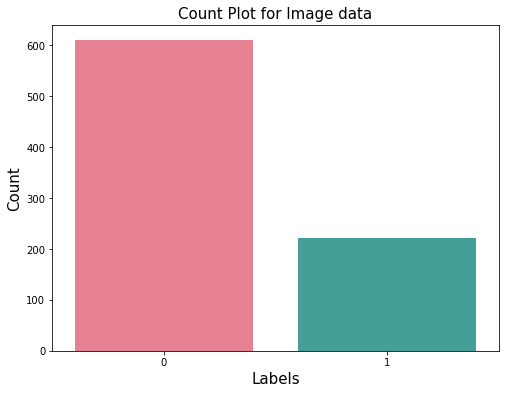

In [108]:
import seaborn as sns
plt.figure(figsize=(8,6))
sns.countplot(labels,palette='husl')
plt.title('Count Plot for Image data', fontsize = 15)
plt.xlabel('Labels', fontsize = 15)
plt.ylabel('Count', fontsize = 15)
plt.show()

In [109]:
# imbalanced data

In [110]:
# print(labels)

### Shape of data

In [111]:
X = np.array(image_data)
y = np.array(labels)

print(X.shape,y.shape)

(831, 256, 256, 3) (831,)


#  Train_test split

In [112]:
from sklearn.model_selection import train_test_split

y_t= tf.keras.utils.to_categorical(y, num_classes=2, dtype='float32')

# Slpitting the X and Y label to train and test
X_train, X_test, y_train, y_test = train_test_split(X,y_t, test_size=0.2, random_state=10)
print(f'Shape of X_train:{X_train.shape}')
print(f'Shape of y_train:{y_train.shape}')
print(f'Shape of X_test:{X_test.shape}')
print(f'Shape of y_test:{y_test.shape}')

Shape of X_train:(664, 256, 256, 3)
Shape of y_train:(664, 2)
Shape of X_test:(167, 256, 256, 3)
Shape of y_test:(167, 2)


# Data Generator

In [21]:
train_datagen = ImageDataGenerator(rescale = 1./255.,rotation_range = 40,
                                   width_shift_range = 0.2, height_shift_range = 0.2,
                                   shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)

test_datagen = ImageDataGenerator( rescale = 1.0/255. )

In [22]:
train_generator = train_datagen.flow(X_train, y_train, shuffle=True)
test_generator = test_datagen.flow(X_test, y_test)

In [23]:
# Adding Callback
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
keras_callbacks=[EarlyStopping(monitor='val_loss',patience=3,
                               mode='min',min_delta=0.01)]

# 1: Base CNN Model

In [24]:
model_1=Sequential()
model_1.add(Conv2D(256,(3,3),activation='relu',input_shape=X_train.shape[1:]))
model_1.add(MaxPooling2D(pool_size=(2,2)))

model_1.add(Conv2D(128,(3,3),activation='relu'))
model_1.add(MaxPooling2D(pool_size=(2,2)))

model_1.add(Conv2D(64,(3,3),activation='relu'))
model_1.add(MaxPooling2D(pool_size=(2,2)))

model_1.add(Conv2D(32,(3,3),activation='relu'))
model_1.add(MaxPooling2D(pool_size=(2,2)))
model_1.add(Flatten())

model_1.add(Dense(units=32,activation='relu'))
model_1.add(Dense(units=2,activation='sigmoid'))

In [25]:
model_1.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [27]:
base_model = model_1.fit(train_generator, epochs=5, validation_data=test_generator, validation_steps=len(test_generator),callbacks=keras_callbacks)

Epoch 1/5
21/21 [==============================] - 523s 25s/step - loss: 0.5833 - accuracy: 0.7289 - val_loss: 0.5400 - val_accuracy: 0.7545
Epoch 2/5
21/21 [==============================] - 461s 23s/step - loss: 0.5563 - accuracy: 0.7244 - val_loss: 0.4602 - val_accuracy: 0.7545
Epoch 3/5
21/21 [==============================] - 476s 23s/step - loss: 0.5637 - accuracy: 0.7289 - val_loss: 0.5075 - val_accuracy: 0.7545
Epoch 4/5
21/21 [==============================] - 456s 22s/step - loss: 0.5481 - accuracy: 0.7289 - val_loss: 0.4235 - val_accuracy: 0.7545
Epoch 5/5
21/21 [==============================] - 452s 21s/step - loss: 0.5851 - accuracy: 0.7289 - val_loss: 0.5196 - val_accuracy: 0.7545


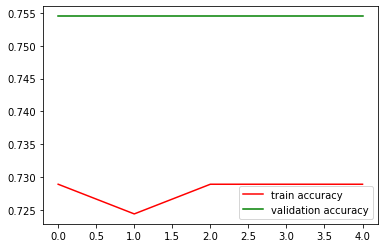

In [28]:
plt.plot(base_model.history['accuracy'],'r',label='train accuracy')
plt.plot(base_model.history['val_accuracy'],'g',label='validation accuracy')
plt.legend()

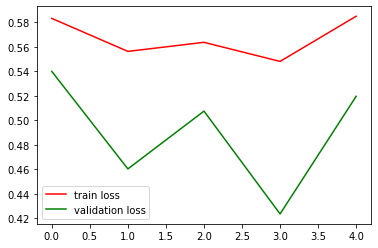

In [29]:
plt.plot(base_model.history['loss'],'r',label='train loss')
plt.plot(base_model.history['val_loss'],'g',label='validation loss')
plt.legend()

In [30]:
test_scores_model_1 = model_1.evaluate(X_test, y_test)

6/6 [==============================] - 16s 3s/step - loss: 1.4072 - accuracy: 0.7605


In [31]:
pred_model_1_train=model_1.predict(X_train)

In [32]:
pred_model_1_test=model_1.predict(X_test)

In [33]:
from sklearn.metrics import classification_report, confusion_matrix
def roundoff(arr):
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

In [35]:
class_names = ['normal', 'parkinson']

In [36]:
for labels in pred_model_1_train:
    labels = roundoff(labels)

print(classification_report(y_train, pred_model_1_train, target_names=class_names))

              precision    recall  f1-score   support

      normal       0.73      0.99      0.84       484
   parkinson       0.30      0.02      0.03       180

   micro avg       0.72      0.72      0.72       664
   macro avg       0.51      0.50      0.43       664
weighted avg       0.61      0.72      0.62       664
 samples avg       0.72      0.72      0.72       664



In [37]:
for labels in pred_model_1_test:
    labels = roundoff(labels)

print(classification_report(y_test, pred_model_1_test, target_names=class_names))

              precision    recall  f1-score   support

      normal       0.76      0.99      0.86       126
   parkinson       0.67      0.05      0.09        41

   micro avg       0.76      0.76      0.76       167
   macro avg       0.71      0.52      0.48       167
weighted avg       0.74      0.76      0.67       167
 samples avg       0.76      0.76      0.76       167



In [52]:
# base_model_train = base_model.history['accuracy']
# base_model_test = base_model.history['val_accuracy']

In [41]:
score_card = pd.DataFrame(columns=['Model_Name','Train_Accuracy','Train_Loss','Validation_Accuracy','Validation_Loss'])

In [42]:
score = pd.Series({'Model_Name':'Base Model_1','Train_Accuracy':base_model.history['accuracy'][-1],'Train_Loss':base_model.history['loss'][-1],'Validation_Accuracy':base_model.history['val_accuracy'][-1],'Validation_Loss':base_model.history['val_loss'][-1]})
score_card=score_card.append(score,ignore_index=True)
score_card

,Model_Name,Train_Accuracy,Train_Loss,Validation_Accuracy,Validation_Loss
0,Base Model_1,0.728916,0.536628,0.754491,0.46915


# SMOTE

In [28]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)

X_res, y_res = sm.fit_resample(X.reshape(X.shape[0], -1), y)
X_res = X_res.reshape(X_res.shape[0], 256, 256, 3)

In [30]:
print(X_res.shape,y_res.shape)

(1220, 256, 256, 3) (1220,)


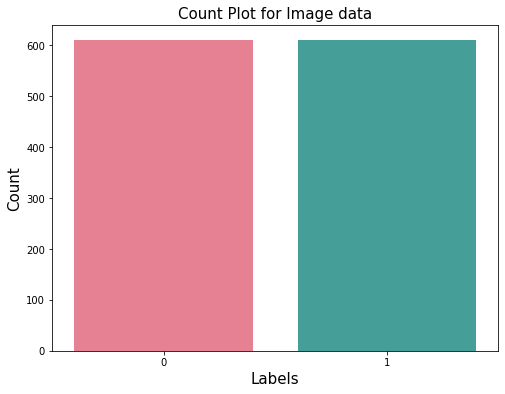

In [31]:
import seaborn as sns
plt.figure(figsize=(8,6))
sns.countplot(y_res,palette='husl')
plt.title('Count Plot for Image data', fontsize = 15)
plt.xlabel('Labels', fontsize = 15)
plt.ylabel('Count', fontsize = 15)
plt.show()

In [32]:
from sklearn.model_selection import train_test_split

y_t_sm= tf.keras.utils.to_categorical(y_res, num_classes=2, dtype='float32')

# Slpitting the X and Y label to train and test
X_train_sm, X_test_sm, y_train_sm, y_test_sm = train_test_split(X_res,y_t_sm, test_size=0.2, random_state=10)
print(f'Shape of X_train:{X_train_sm.shape}')
print(f'Shape of y_train:{y_train_sm.shape}')
print(f'Shape of X_test:{X_test_sm.shape}')
print(f'Shape of y_test:{y_test_sm.shape}')

Shape of X_train:(976, 256, 256, 3)
Shape of y_train:(976, 2)
Shape of X_test:(244, 256, 256, 3)
Shape of y_test:(244, 2)


In [33]:
train_generator_sm = train_datagen.flow(X_train_sm, y_train_sm, shuffle=True)
test_generator_sm = test_datagen.flow(X_test_sm, y_test_sm)

#  Base CNN model after appling smote

In [35]:
model_2=Sequential()
model_2.add(Conv2D(256,(3,3),activation='relu',input_shape=X_train_sm.shape[1:]))
model_2.add(MaxPooling2D(pool_size=(2,2)))

model_2.add(Conv2D(128,(3,3),activation='relu'))
model_2.add(MaxPooling2D(pool_size=(2,2)))

model_2.add(Conv2D(64,(3,3),activation='relu'))
model_2.add(MaxPooling2D(pool_size=(2,2)))

model_2.add(Conv2D(32,(3,3),activation='relu'))
model_2.add(MaxPooling2D(pool_size=(2,2)))

model_2.add(Flatten())

model_2.add(Dense(units=32,activation='relu'))
model_2.add(Dense(units=2,activation='sigmoid'))

In [36]:
model_2.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [37]:
base_model_smote = model_2.fit(train_generator_sm, epochs=30, validation_data=test_generator_sm, validation_steps=len(test_generator_sm),callbacks=keras_callbacks)

Epoch 1/30
31/31 [==============================] - 17s 531ms/step - loss: 0.6533 - accuracy: 0.5727 - val_loss: 0.6136 - val_accuracy: 0.6434
Epoch 2/30
31/31 [==============================] - 14s 464ms/step - loss: 0.6068 - accuracy: 0.6547 - val_loss: 0.4937 - val_accuracy: 0.7705
Epoch 3/30
31/31 [==============================] - 15s 475ms/step - loss: 0.6200 - accuracy: 0.6055 - val_loss: 0.6118 - val_accuracy: 0.6598
Epoch 4/30
31/31 [==============================] - 14s 455ms/step - loss: 0.5717 - accuracy: 0.6742 - val_loss: 0.3662 - val_accuracy: 0.8730
Epoch 5/30
31/31 [==============================] - 15s 472ms/step - loss: 0.4858 - accuracy: 0.7756 - val_loss: 0.4275 - val_accuracy: 0.8115
Epoch 6/30
31/31 [==============================] - 14s 456ms/step - loss: 0.4808 - accuracy: 0.8074 - val_loss: 0.2400 - val_accuracy: 0.9262
Epoch 7/30
31/31 [==============================] - 14s 454ms/step - loss: 0.4174 - accuracy: 0.8156 - val_loss: 0.2410 - val_accuracy: 0.9180

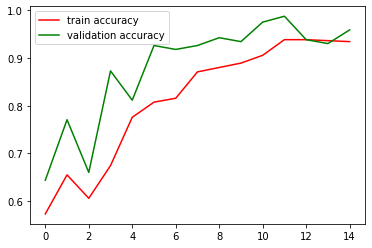

In [38]:
plt.plot(base_model_smote.history['accuracy'],'r',label='train accuracy')
plt.plot(base_model_smote.history['val_accuracy'],'g',label='validation accuracy')
plt.legend()

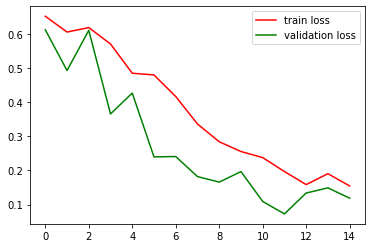

In [39]:
plt.plot(base_model_smote.history['loss'],'r',label='train loss')
plt.plot(base_model_smote.history['val_loss'],'g',label='validation loss')
plt.legend()

In [53]:
# model2_train = base_model_smote.history['accuracy']
# model2_test = base_model_smote.history['val_accuracy']

In [43]:
score = pd.Series({'Model_Name':'Base_model_smote_2','Train_Accuracy':base_model_smote.history['accuracy'][-1],'Train_Loss':base_model_smote.history['loss'][-1],'Validation_Accuracy':base_model_smote.history['val_accuracy'][-1],'Validation_Loss':base_model_smote.history['val_loss'][-1]})
score_card=score_card.append(score,ignore_index=True)
score_card

,Model_Name,Train_Accuracy,Train_Loss,Validation_Accuracy,Validation_Loss
0,Base Model_1,0.728916,0.536628,0.754491,0.469150
1,Base_model_smote_2,0.934426,0.154563,0.959016,0.118624


# Cnn model with modification

In [46]:
model3=Sequential()
model3.add(Conv2D(128,(3,3),activation='relu',input_shape=X_train_sm.shape[1:]))
model3.add(MaxPooling2D(pool_size=(2,2)))

model3.add(Conv2D(64,(3,3),activation='relu'))
model3.add(MaxPooling2D(pool_size=(2,2)))

model3.add(Conv2D(16,(3,3),activation='relu'))
model3.add(MaxPooling2D(pool_size=(2,2)))
model3.add(Flatten())

model3.add(Dense(units=32,activation='relu'))
model3.add(Dense(units=16,activation='relu'))
model3.add(Dense(units=2,activation='sigmoid'))

In [47]:
model3.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [48]:
model_3 = model3.fit(train_generator_sm, epochs=30, validation_data=test_generator_sm, validation_steps=len(test_generator_sm),callbacks=keras_callbacks)

Epoch 1/30
31/31 [==============================] - 15s 433ms/step - loss: 0.6723 - accuracy: 0.5605 - val_loss: 0.6435 - val_accuracy: 0.5984
Epoch 2/30
31/31 [==============================] - 13s 419ms/step - loss: 0.6265 - accuracy: 0.6250 - val_loss: 0.5942 - val_accuracy: 0.6680
Epoch 3/30
31/31 [==============================] - 14s 436ms/step - loss: 0.6091 - accuracy: 0.6752 - val_loss: 0.4813 - val_accuracy: 0.7664
Epoch 4/30
31/31 [==============================] - 13s 413ms/step - loss: 0.5242 - accuracy: 0.7316 - val_loss: 0.3792 - val_accuracy: 0.8811
Epoch 5/30
31/31 [==============================] - 14s 436ms/step - loss: 0.5155 - accuracy: 0.7643 - val_loss: 0.3776 - val_accuracy: 0.8811
Epoch 6/30
31/31 [==============================] - 13s 420ms/step - loss: 0.4366 - accuracy: 0.8105 - val_loss: 0.2662 - val_accuracy: 0.9057
Epoch 7/30
31/31 [==============================] - 14s 442ms/step - loss: 0.4227 - accuracy: 0.8115 - val_loss: 0.2619 - val_accuracy: 0.9016

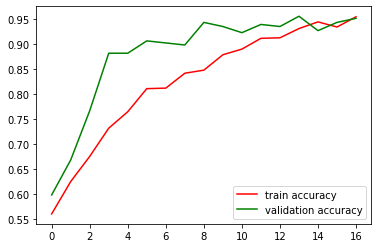

In [49]:
plt.plot(model_3.history['accuracy'],'r',label='train accuracy')
plt.plot(model_3.history['val_accuracy'],'g',label='validation accuracy')
plt.legend()

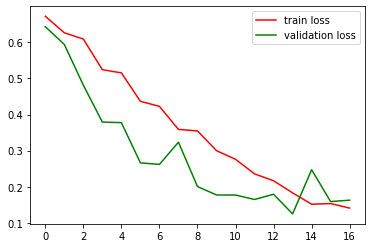

In [50]:
plt.plot(model_3.history['loss'],'r',label='train loss')
plt.plot(model_3.history['val_loss'],'g',label='validation loss')
plt.legend()

In [54]:
# model3_train = model_3.history['accuracy']
# model3_test = model_3.history['val_accuracy']

In [51]:
score = pd.Series({'Model_Name':'Model_3','Train_Accuracy':model_3.history['accuracy'][-1],'Train_Loss':model_3.history['loss'][-1],'Validation_Accuracy':model_3.history['val_accuracy'][-1],'Validation_Loss':model_3.history['val_loss'][-1]})
score_card=score_card.append(score,ignore_index=True)
score_card

,Model_Name,Train_Accuracy,Train_Loss,Validation_Accuracy,Validation_Loss
0,Base Model_1,0.728916,0.536628,0.754491,0.469150
1,Base_model_smote_2,0.934426,0.154563,0.959016,0.118624
2,Model_3,0.953893,0.140960,0.950820,0.162867


# RESNET

In [66]:
from tensorflow.keras.applications.resnet50 import ResNet50
model_r = ResNet50(include_top = False,weights = 'imagenet',input_shape = (256,256,3))

94781440/94765736 [==============================] - 0s 0us/step


In [67]:
model_r.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [68]:
for ix in range(len(model_r.layers)):
    print(ix,model_r.layers[ix])

0 <keras.engine.input_layer.InputLayer object at 0x7fc33c21e9d0>
1 <keras.layers.convolutional.ZeroPadding2D object at 0x7fc33c5d3b90>
2 <keras.layers.convolutional.Conv2D object at 0x7fc33c216b50>
3 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fc33c14dad0>
4 <keras.layers.core.Activation object at 0x7fc33c14be90>
5 <keras.layers.convolutional.ZeroPadding2D object at 0x7fc33c14d810>
6 <keras.layers.pooling.MaxPooling2D object at 0x7fc33c0f4510>
7 <keras.layers.convolutional.Conv2D object at 0x7fc33c1421d0>
8 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fc33c10a510>
9 <keras.layers.core.Activation object at 0x7fc33c11b6d0>
10 <keras.layers.convolutional.Conv2D object at 0x7fc33c142950>
11 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fc33c11e390>
12 <keras.layers.core.Activation object at 0x7fc33c142810>
13 <keras.layers.convolutional.Conv2D object at 0x7fc33c0f9b50>
14 <keras.layers.

In [69]:
# 6l
for layer in model_r.layers[:169]:
    layer.trainable = False
for i, layer in enumerate(model_r.layers):
    print(i, layer.name, layer.trainable)

0 input_2 False
1 conv1_pad False
2 conv1_conv False
3 conv1_bn False
4 conv1_relu False
5 pool1_pad False
6 pool1_pool False
7 conv2_block1_1_conv False
8 conv2_block1_1_bn False
9 conv2_block1_1_relu False
10 conv2_block1_2_conv False
11 conv2_block1_2_bn False
12 conv2_block1_2_relu False
13 conv2_block1_0_conv False
14 conv2_block1_3_conv False
15 conv2_block1_0_bn False
16 conv2_block1_3_bn False
17 conv2_block1_add False
18 conv2_block1_out False
19 conv2_block2_1_conv False
20 conv2_block2_1_bn False
21 conv2_block2_1_relu False
22 conv2_block2_2_conv False
23 conv2_block2_2_bn False
24 conv2_block2_2_relu False
25 conv2_block2_3_conv False
26 conv2_block2_3_bn False
27 conv2_block2_add False
28 conv2_block2_out False
29 conv2_block3_1_conv False
30 conv2_block3_1_bn False
31 conv2_block3_1_relu False
32 conv2_block3_2_conv False
33 conv2_block3_2_bn False
34 conv2_block3_2_relu False
35 conv2_block3_3_conv False
36 conv2_block3_3_bn False
37 conv2_block3_add False
38 conv2_bloc

In [70]:
resnet = tf.keras.Sequential([
  model_r,
  GlobalAveragePooling2D(),
  Dropout(0.2),
  Dense(64,activation='relu'),
  Dropout(0.2),
  Dense(64,activation='relu'),
  Dropout(0.2),
  Dense(2, activation='sigmoid')])

In [71]:
adam = Adam(learning_rate=0.00001)
resnet.compile(optimizer=adam,loss='binary_crossentropy',metrics=['accuracy'])

In [72]:
resnet_model= resnet.fit(train_generator_sm, epochs=30, validation_data=test_generator_sm, validation_steps=len(test_generator_sm),callbacks=keras_callbacks)

Epoch 1/30
31/31 [==============================] - 18s 467ms/step - loss: 0.7092 - accuracy: 0.5092 - val_loss: 0.7030 - val_accuracy: 0.5082
Epoch 2/30
31/31 [==============================] - 13s 434ms/step - loss: 0.7112 - accuracy: 0.5000 - val_loss: 0.6966 - val_accuracy: 0.5082
Epoch 3/30
31/31 [==============================] - 14s 457ms/step - loss: 0.6923 - accuracy: 0.5543 - val_loss: 0.6941 - val_accuracy: 0.5205
Epoch 4/30
31/31 [==============================] - 14s 449ms/step - loss: 0.6938 - accuracy: 0.5379 - val_loss: 0.6894 - val_accuracy: 0.7213
Epoch 5/30
31/31 [==============================] - 14s 455ms/step - loss: 0.6832 - accuracy: 0.6014 - val_loss: 0.6846 - val_accuracy: 0.6762
Epoch 6/30
31/31 [==============================] - 14s 435ms/step - loss: 0.6779 - accuracy: 0.6260 - val_loss: 0.6767 - val_accuracy: 0.6516
Epoch 7/30
31/31 [==============================] - 15s 472ms/step - loss: 0.6733 - accuracy: 0.6096 - val_loss: 0.6646 - val_accuracy: 0.6885

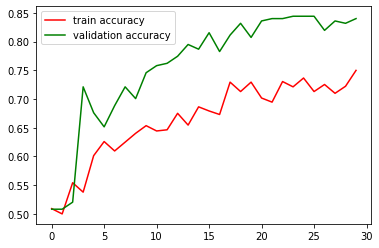

In [73]:
plt.plot(resnet_model.history['accuracy'],'r',label='train accuracy')
plt.plot(resnet_model.history['val_accuracy'],'g',label='validation accuracy')
plt.legend()
plt.show()

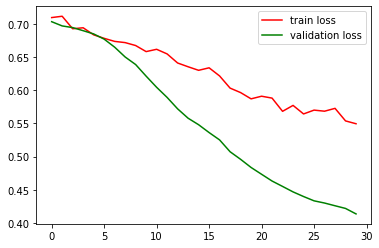

In [74]:
plt.plot(resnet_model.history['loss'],'r',label='train loss')
plt.plot(resnet_model.history['val_loss'],'g',label='validation loss')
plt.legend()
plt.show()

In [75]:
# model4_train = resnet_model.history['accuracy']
# model4_test = resnet_model.history['val_accuracy']

In [88]:
score = pd.Series({'Model_Name':'Model 4 TransferLearning(RESNET-50)','Train_Accuracy':resnet_model.history['accuracy'][-1],'Train_Loss':resnet_model.history['loss'][-1],'Validation_Accuracy':resnet_model.history['val_accuracy'][-1],'Validation_Loss':resnet_model.history['val_loss'][-1]})
score_card=score_card.append(score,ignore_index=True)
score_card

,Model_Name,Train_Accuracy,Train_Loss,Validation_Accuracy,Validation_Loss
0,Base_Model_1,0.728916,0.536628,0.754491,0.469150
1,Base_model_smote_2,0.934426,0.154563,0.959016,0.118624
2,Model_3,0.953893,0.140960,0.950820,0.162867
3,Model 4 TransferLearning(RESNET-50),0.750000,0.549434,0.840164,0.413794


In [ ]:
# loss is high and under fitting

# Xception

In [77]:
from tensorflow.keras.applications import Xception
model_x = Xception(include_top=False, input_shape=(256,256,3), weights='imagenet')

83697664/83683744 [==============================] - 1s 0us/step


In [78]:
model_x.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 127, 127, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 127, 127, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 127, 127, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [79]:
for ix in range(len(model6_x.layers)):
    print(ix,model6_x.layers[ix])

0 <keras.engine.input_layer.InputLayer object at 0x7fc7509e0990>
1 <keras.layers.convolutional.Conv2D object at 0x7fc2e12e5f90>
2 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fc750a30810>
3 <keras.layers.core.Activation object at 0x7fc7509d5d10>
4 <keras.layers.convolutional.Conv2D object at 0x7fc7509e0650>
5 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fc7509ff810>
6 <keras.layers.core.Activation object at 0x7fc750986c50>
7 <keras.layers.convolutional.SeparableConv2D object at 0x7fc750999890>
8 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fc7509a0f90>
9 <keras.layers.core.Activation object at 0x7fc7509a49d0>
10 <keras.layers.convolutional.SeparableConv2D object at 0x7fc7509a7d90>
11 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fc7509b8a50>
12 <keras.layers.convolutional.Conv2D object at 0x7fc75098aa90>
13 <keras.layers.pooling.MaxPooling2D object 

In [80]:
# 5 L
for layer in model_x.layers[:127]:
    layer.trainable = False
for i, layer in enumerate(model_x.layers):
    print(i, layer.name, layer.trainable)

0 input_3 False
1 block1_conv1 False
2 block1_conv1_bn False
3 block1_conv1_act False
4 block1_conv2 False
5 block1_conv2_bn False
6 block1_conv2_act False
7 block2_sepconv1 False
8 block2_sepconv1_bn False
9 block2_sepconv2_act False
10 block2_sepconv2 False
11 block2_sepconv2_bn False
12 conv2d_26 False
13 block2_pool False
14 batch_normalization False
15 add False
16 block3_sepconv1_act False
17 block3_sepconv1 False
18 block3_sepconv1_bn False
19 block3_sepconv2_act False
20 block3_sepconv2 False
21 block3_sepconv2_bn False
22 conv2d_27 False
23 block3_pool False
24 batch_normalization_1 False
25 add_1 False
26 block4_sepconv1_act False
27 block4_sepconv1 False
28 block4_sepconv1_bn False
29 block4_sepconv2_act False
30 block4_sepconv2 False
31 block4_sepconv2_bn False
32 conv2d_28 False
33 block4_pool False
34 batch_normalization_2 False
35 add_2 False
36 block5_sepconv1_act False
37 block5_sepconv1 False
38 block5_sepconv1_bn False
39 block5_sepconv2_act False
40 block5_sepconv2 

In [81]:
xception = tf.keras.Sequential([
  model_x,
  GlobalAveragePooling2D(),
  Dropout(0.2),
  Dense(64,activation='relu'),
  Dropout(0.2),
  Dense(64,activation='relu'),
  Dropout(0.2),
  Dense(2, activation='sigmoid')])

In [82]:
adam = Adam(learning_rate=0.00001)
xception.compile(optimizer=adam,loss='binary_crossentropy',metrics=['accuracy'])

In [83]:
xception_model= xception.fit(train_generator_sm, epochs=30, validation_data=test_generator_sm, validation_steps=len(test_generator_sm),callbacks=keras_callbacks)

Epoch 1/30
31/31 [==============================] - 18s 485ms/step - loss: 0.6919 - accuracy: 0.5605 - val_loss: 0.6798 - val_accuracy: 0.6148
Epoch 2/30
31/31 [==============================] - 15s 471ms/step - loss: 0.6797 - accuracy: 0.6086 - val_loss: 0.6632 - val_accuracy: 0.7090
Epoch 3/30
31/31 [==============================] - 14s 463ms/step - loss: 0.6671 - accuracy: 0.6547 - val_loss: 0.6458 - val_accuracy: 0.7828
Epoch 4/30
31/31 [==============================] - 15s 474ms/step - loss: 0.6565 - accuracy: 0.6936 - val_loss: 0.6291 - val_accuracy: 0.8115
Epoch 5/30
31/31 [==============================] - 14s 449ms/step - loss: 0.6447 - accuracy: 0.7264 - val_loss: 0.6124 - val_accuracy: 0.8484
Epoch 6/30
31/31 [==============================] - 14s 466ms/step - loss: 0.6352 - accuracy: 0.7500 - val_loss: 0.5949 - val_accuracy: 0.8689
Epoch 7/30
31/31 [==============================] - 14s 454ms/step - loss: 0.6165 - accuracy: 0.7787 - val_loss: 0.5762 - val_accuracy: 0.8852

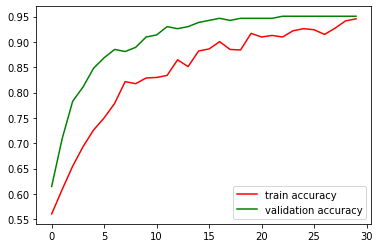

In [84]:
plt.plot(xception_model.history['accuracy'],'r',label='train accuracy')
plt.plot(xception_model.history['val_accuracy'],'g',label='validation accuracy')
plt.legend()
plt.show()

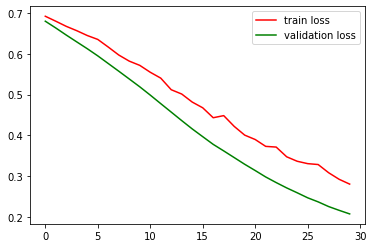

In [85]:
plt.plot(xception_model.history['loss'],'r',label='train loss')
plt.plot(xception_model.history['val_loss'],'g',label='validation loss')
plt.legend()
plt.show()

In [86]:
# model5_train = xception_model.history['accuracy']
# model5_test = xception_model.history['val_accuracy']

In [89]:
score = pd.Series({'Model_Name':'Model 5 TransferLearning(Xception)','Train_Accuracy':xception_model.history['accuracy'][-1],'Train_Loss':xception_model.history['loss'][-1],'Validation_Accuracy':xception_model.history['val_accuracy'][-1],'Validation_Loss':xception_model.history['val_loss'][-1]})
score_card=score_card.append(score,ignore_index=True)
score_card

,Model_Name,Train_Accuracy,Train_Loss,Validation_Accuracy,Validation_Loss
0,Base_Model_1,0.728916,0.536628,0.754491,0.469150
1,Base_model_smote_2,0.934426,0.154563,0.959016,0.118624
2,Model_3,0.953893,0.140960,0.950820,0.162867
3,Model 4 TransferLearning(RESNET-50),0.750000,0.549434,0.840164,0.413794
4,Model 5 TransferLearning(Xception),0.945697,0.281002,0.950820,0.208044


# Vgg16

In [55]:
from keras.applications.vgg16 import VGG16
IMG_SHAPE = (256, 256, 3)
model_vgg16 = VGG16(input_shape=IMG_SHAPE, include_top=False,weights='imagenet')

58900480/58889256 [==============================] - 0s 0us/step


In [56]:
model_vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [57]:
for ix in range(len(model_vgg16.layers)):
    print(ix,model_vgg16.layers[ix])

0 <keras.engine.input_layer.InputLayer object at 0x7fc33c5d3f90>
1 <keras.layers.convolutional.Conv2D object at 0x7fc33c560a50>
2 <keras.layers.convolutional.Conv2D object at 0x7fc33c560e90>
3 <keras.layers.pooling.MaxPooling2D object at 0x7fc33c564a50>
4 <keras.layers.convolutional.Conv2D object at 0x7fc33c5ae610>
5 <keras.layers.convolutional.Conv2D object at 0x7fc34c039410>
6 <keras.layers.pooling.MaxPooling2D object at 0x7fc33c5714d0>
7 <keras.layers.convolutional.Conv2D object at 0x7fc33c575cd0>
8 <keras.layers.convolutional.Conv2D object at 0x7fc33c571a10>
9 <keras.layers.convolutional.Conv2D object at 0x7fc33c57cbd0>
10 <keras.layers.pooling.MaxPooling2D object at 0x7fc33c588110>
11 <keras.layers.convolutional.Conv2D object at 0x7fc33c5838d0>
12 <keras.layers.convolutional.Conv2D object at 0x7fc33c56da10>
13 <keras.layers.convolutional.Conv2D object at 0x7fc33c590c10>
14 <keras.layers.pooling.MaxPooling2D object at 0x7fc33c59ac50>
15 <keras.layers.convolutional.Conv2D object at 

In [58]:
# 4layer
for layer in model_vgg16.layers[:15]:
    layer.trainable=False
    
for layer in model_vgg16.layers:
    print(layer,layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7fc33c5d3f90> False
<keras.layers.convolutional.Conv2D object at 0x7fc33c560a50> False
<keras.layers.convolutional.Conv2D object at 0x7fc33c560e90> False
<keras.layers.pooling.MaxPooling2D object at 0x7fc33c564a50> False
<keras.layers.convolutional.Conv2D object at 0x7fc33c5ae610> False
<keras.layers.convolutional.Conv2D object at 0x7fc34c039410> False
<keras.layers.pooling.MaxPooling2D object at 0x7fc33c5714d0> False
<keras.layers.convolutional.Conv2D object at 0x7fc33c575cd0> False
<keras.layers.convolutional.Conv2D object at 0x7fc33c571a10> False
<keras.layers.convolutional.Conv2D object at 0x7fc33c57cbd0> False
<keras.layers.pooling.MaxPooling2D object at 0x7fc33c588110> False
<keras.layers.convolutional.Conv2D object at 0x7fc33c5838d0> False
<keras.layers.convolutional.Conv2D object at 0x7fc33c56da10> False
<keras.layers.convolutional.Conv2D object at 0x7fc33c590c10> False
<keras.layers.pooling.MaxPooling2D object at 0x7fc33c59ac50>

In [59]:
Transfer_model_vgg = tf.keras.Sequential([
  model_vgg16,
  GlobalAveragePooling2D(),
  Dropout(0.2),
  Dense(64,activation='relu'),
  Dropout(0.2),
  Dense(64,activation='relu'),
  Dropout(0.2),
  Dense(2, activation='sigmoid')])

In [60]:
adam = Adam(learning_rate=0.00003)
Transfer_model_vgg.compile(optimizer=adam,loss='binary_crossentropy',metrics=['accuracy'])

In [61]:
vgg_model = Transfer_model_vgg.fit(train_generator_sm, epochs=20, validation_data=test_generator_sm, validation_steps=len(test_generator_sm),callbacks=keras_callbacks)

Epoch 1/20
31/31 [==============================] - 22s 569ms/step - loss: 0.7032 - accuracy: 0.5779 - val_loss: 0.5921 - val_accuracy: 0.8402
Epoch 2/20
31/31 [==============================] - 14s 461ms/step - loss: 0.5281 - accuracy: 0.7736 - val_loss: 0.2462 - val_accuracy: 0.9467
Epoch 3/20
31/31 [==============================] - 14s 439ms/step - loss: 0.3156 - accuracy: 0.8852 - val_loss: 0.1261 - val_accuracy: 0.9672
Epoch 4/20
31/31 [==============================] - 14s 469ms/step - loss: 0.2078 - accuracy: 0.9293 - val_loss: 0.0813 - val_accuracy: 0.9754
Epoch 5/20
31/31 [==============================] - 14s 442ms/step - loss: 0.1379 - accuracy: 0.9611 - val_loss: 0.0811 - val_accuracy: 0.9754
Epoch 6/20
31/31 [==============================] - 14s 466ms/step - loss: 0.0982 - accuracy: 0.9723 - val_loss: 0.1090 - val_accuracy: 0.9590
Epoch 7/20
31/31 [==============================] - 14s 449ms/step - loss: 0.0926 - accuracy: 0.9734 - val_loss: 0.0830 - val_accuracy: 0.9713

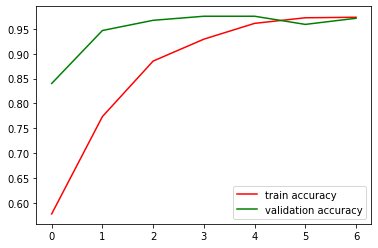

In [62]:
plt.plot(vgg_model.history['accuracy'],'r',label='train accuracy')
plt.plot(vgg_model.history['val_accuracy'],'g',label='validation accuracy')
plt.legend()
plt.show()

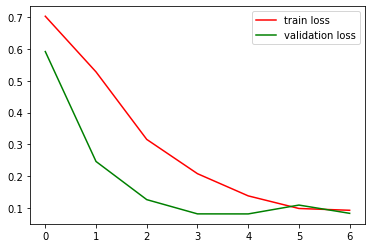

In [63]:
plt.plot(vgg_model.history['loss'],'r',label='train loss')
plt.plot(vgg_model.history['val_loss'],'g',label='validation loss')
plt.legend()
plt.show()

In [ ]:
# serialize model to JSON
model_json = vgg.to_json()
with open("Model_6.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
vgg.save_weights("Model_6.h5")

In [64]:
# model6_train = vgg_model.history['accuracy']
# model6_test = vgg_model.history['val_accuracy']

In [90]:
score = pd.Series({'Model_Name':'Model 6 TransferLearning(VGG-16)','Train_Accuracy':vgg_model.history['accuracy'][-1],'Train_Loss':vgg_model.history['loss'][-1],'Validation_Accuracy':vgg_model.history['val_accuracy'][-1],'Validation_Loss':vgg_model.history['val_loss'][-1]})
score_card=score_card.append(score,ignore_index=True)
score_card

,Model_Name,Train_Accuracy,Train_Loss,Validation_Accuracy,Validation_Loss
0,Base_Model_1,0.728916,0.536628,0.754491,0.469150
1,Base_model_smote_2,0.934426,0.154563,0.959016,0.118624
2,Model_3,0.953893,0.140960,0.950820,0.162867
3,Model 4 TransferLearning(RESNET-50),0.750000,0.549434,0.840164,0.413794
4,Model 5 TransferLearning(Xception),0.945697,0.281002,0.950820,0.208044
5,Model 6 TransferLearning(VGG-16),0.973361,0.092590,0.971311,0.082992


Comparing all the model accuracy and loss values Model 3[CNN model] and Model 6[Vgg16] is chosen for Parkinson's Disease Prediction.

Vgg16 model weights are used to deploy the project using streamlit

<h1> <b> *******************************************************************************************